In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.optimize import minimize
%matplotlib inline

## Neural networks

---
In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

Load the data and view some samples in the same way as [ex3](https://github.com/rickwierenga/CS229-Python/tree/master/ex3).

Remember the output of a neural network: $h_\Theta(x) \in \mathbb{R}^K$. We want y to be a 2 dimensional vector in the form that are network should output. For example, we would represent the output 1 as:

$\begin{bmatrix}0\\1\\0\\0\\0\\0\\0\\0\\0\\0\end{bmatrix}$

In [2]:
def remap(y, K):
    """
    Convert input map to map standard
    :param y: map input
    :param K: number class
    :return: output map convert
    """
    m = len(y)
    out = np.zeros((m, K))
    for index in range(m):
        out[index][y[index] - 1] = 1
    return out

In [5]:
import scipy.io as sio

# Load data
data = sio.loadmat("ex4data1.mat")
X = data["X"]
y = data["y"]
y = y.reshape(len(y))

# Initialize some useful variables
m, n = X.shape
input_layer_size = 400
hidden_layer_size = 25
K = 10 # number of classes / output_layer_size

# remap y
mapped_y = remap(y, K)

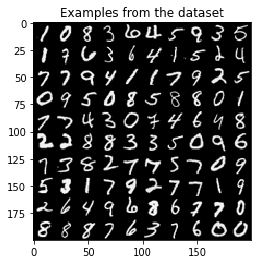

In [6]:
import random
from PIL import Image

# get 100 random images from the dataset
num_samples = 100
samples = random.sample(list(X), num_samples)
display_img = Image.new('RGB', (200, 200))

# loop over the images, turn them into a PIL image
i = 0
for col in range(10):
    for row in range(10):
        array = samples[i]
        array = ((array / max(array)) * 255).reshape((20, 20)).transpose() # redistribute values
        img = Image.fromarray(array)
        display_img.paste(img, (col*20, row*20))
        i += 1

# present display_img
plt.title('Examples from the dataset')
plt.imshow(display_img, interpolation='nearest')

Load the provided weights.

In [7]:
# load the pretrained weights
theta = sio.loadmat("ex4weights.mat")
theta_1 = theta['Theta1'] # shape 25x401
theta_2 = theta['Theta2']   #shape 10x26
nn_params = np.concatenate([theta_1.flatten(), theta_2.flatten()])

### Feedforward
These are the functions for doing feedforward as written [ex3](https://github.com/rickwierenga/CS229-Python/tree/master/ex3).

In [8]:
def sigmoid(z):
    """
    Sigmoid function
    :param z: input of sigmoid function
    :return: result of sigmoid finction with z
    """
    return 1 / (1 + np.exp(-z))

def add_bias(X):
    """
    Add bias param to weights
    :param X: weights
    :return: append bias with weight
    """
    m = len(X)
    bias = np.ones(m)
    X = np.vstack((bias, X.T)).T
    return X

def forward(theta, X):
    """
    Forward next layer neuron network with sigmoid activate function
    :param theta: Theta
    :param X: input layer
    :return: output layer
    """
    return sigmoid(theta @ X)

### Cost Function

Remember the following variables from the lectures: 

* $L$: Total number of layers in the network
* $s_l$: number of units (not counting bias unit) in layer $l$.
* $K$: number of output classes

The cost function for neural networks without regularization:

$$J(\theta) = \frac{1}{m}\displaystyle\sum_{i=1}^{m}\displaystyle\sum_{k=1}^{K}\begin{bmatrix} -y^{(i)}_k \log (h_\theta(x^{(i)}) - (1 - y^{(i)})_k \log(1-(h_\theta(x^{(i)}))_k)\end{bmatrix}$$

And with regularization:

$$J(\theta) = -\frac{1}{m}\displaystyle\sum_{i=1}^{m}\displaystyle\sum_{k=1}^{K}\begin{bmatrix} -y^{(i)}_k \log ((h_\theta(x^{(i)}-(1-y^{(i)})_k) \log(1-(h_\theta(x^{(i)}))_k)\end{bmatrix} + \frac{\lambda}{2m} \displaystyle\sum_{l=1}^{L-1}\displaystyle\sum_{i=1}^{s_l}\displaystyle\sum_{j=1}^{s_l+1}(\Theta^{(l)}_{ji})^2$$

The double sum adds up the costs for each cell in the output layer. The triple sum adds up the squares of all $\Theta$s in the network.

**Exercise**: Implement the cost function for neural networks, `compute_nn_cost`, in Python. There are some structural comments to help you.

In [9]:
def compute_nn_cost(nn_params, X, y, input_layer_size, hidden_layer_size, K, _lambda=0):
    """

    :param nn_params: total theta parameter = 10,285
    :param X: input (shape 5000x400)
    :param y: target of X # map_y (shape 5000x10)
    :param input_layer_size: input layer size (X.shape[1])
    :param hidden_layer_size: hidden layer size (25)
    :param K: number class (10)
    :param _lambda: variables using to computes regulazation
    :return: cost value for neural networks
    """
    m = len(y)

    # Extract theta_1 and theta_2 from nn_params
    theta_1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, (input_layer_size + 1)))  # shape 25x401
    theta_2 = nn_params[(hidden_layer_size * (input_layer_size + 1)):].reshape((K, (hidden_layer_size + 1)))  # shape 10x26

    # Feed forward the network to get the predictions
    activation_layer_1 = add_bias(forward(theta_1, add_bias(X).T).T)  # shape = 5000x26
    predictions = forward(theta_2, activation_layer_1.T).T  # shape = 5000x10

    # Compute the cost of the current prediction
    network_cost = (1 / m) * np.sum(-y * np.log(predictions) - (1 - y) * np.log(1 - predictions))
    regularization = (_lambda / (2 * m)) * (np.sum(theta_1 ** 2) + np.sum(theta_2 ** 2))

    return network_cost + regularization

In [10]:
J = compute_nn_cost(nn_params, X, mapped_y,
                    input_layer_size=input_layer_size,
                    hidden_layer_size=hidden_layer_size,
                    K=10)
_lambda = 1
J_reg = compute_nn_cost(nn_params, X, mapped_y,
                        input_layer_size=input_layer_size,
                        hidden_layer_size=hidden_layer_size,
                        K=10,
                        _lambda=_lambda)

print('Cost without regularization: {:2}% (0.29 approx)'.format(J))
print('Cost with regularization: {:2}% (0.38 approx)'.format(J_reg))

Cost without regularization: 0.2876291651613189% (0.29 approx)
Cost with regularization: 0.384487796242894% (0.38 approx)


## Backpropogation

---

### The Algorithm
As the name suggests, backpropogation is roughly the opposite of feedforward propogation. Backpropogation is an algorithm that trains neural networks by computing the gradient and thereupon applying it to the neural network.

Backpropogation (Backprop) starts at the end of the network. It finds the difference between the output of the neural network and the desired output. This value gets stored in $\delta_j^{(l)}$, the error/cost for $a_j^{(l)}$. Also, $\frac{\delta}{\delta z_j^{(l)}} = \delta_j^{(l)}$. The process formaly:

$$\delta_j^{(l)} = a_j^{(l)} - y_j$$ for $l = L$

$$\delta_j^{(l)} = (\Theta^{(l)})^T\delta^{(l+1)} .* g'(z^{(l)}) = (\Theta^{(l)})^T\delta^{(l+1)} .* \delta^{(l)}$$ for $L > l > 1$

Also: 

$$D^{(l)}_{ij} = \frac{\delta}{\delta \Theta_j^{(l)}}J(\Theta)$$

As you would probably have expected, we don't apply the gradient to the input layer, layer 1, because we don't want to change our input in order to get a better output.

The complete algorithm:

Set $\Delta^{(l)}_{ij} = 0$ for all ($l$, $i$, $j$)

for $i = $ to $m$
1. Perform forward propogation to compute $a^{(l)}$ for $l = 2, 3, ..., L$
2. Using $y^{(l)}$, compute $\delta^{(L)} = a^{(L)} - y^{(i)}$
3. Compute $\delta^{(L-2)}$, ..., $\delta^{(2)}$
4. $\Delta^{(l)}_{ij} := \Delta^{(l)}_{ij} + a^{(l)}_j\delta^{(l+1)}_i$

$D^{(l)}_{i0} = \frac{1}{m}\Delta^{(l)}_{i0}$

$D^{(l)}_{ij} = \frac{1}{m}\Delta^{(l)}_{ij} + \lambda\Theta^{(l)}_{ij}$ if y $\neq 0$

### Gradient Checking
After you've implemented code to compute the gradient, it's often a good idea to validate your code by comparing the gradient to an approximation of it. The approximiation is defined as: 

$$\frac{J(\theta+\epsilon) - J(\theta-\epsilon)}{2\epsilon} \approx D$$

### Random Initialization

If all values in the neural networks are the same, the neural network will fail to develop advanced patterns and it will not function. This is the reason we use a random value for theta as the initial input (break the symmetry).

### Neural Network Traning
Follow these steps when training a neural network:
1. Randomly initialize weights (avoid **symmetric ... **)
2. Implement forward propogation to get $h_\Theta(x^{(i)})$ from any $x^{(i)}$.
3. Implement code to compute cost function $J(\Theta)$.
4. Implement backprop to compute partial derrivatives $\frac{\delta}{\delta \Theta^{(l)}_{jk}}J(\Theta)$. 
    * Usually with a for loop over the training examples:
        * Perform forward and backward propogation using one example
        * Get activations $a^{(l)}$ and delta terms $d^{(l)}$ for $l = 2, ..., L$
5. Use gradient checking to compare $\frac{\delta}{\delta \Theta^{(l)}_{jk}}J(\Theta)$ computed using back propogation vs. using numerical estate of gradient of $J(\Theta)$. Then disable gradient checking code.
6. Use gradient descent or advanced optimization method with backpropogation to try to minimize $J(\Theta)$ as a function of parameters $\Theta$.

---

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(\theta)$ using an advanced optimization algorithm such as cg.

### Sigmoid Gradient
**Exercise**: Implement the gradient for the sigmoid function.

In [11]:
def sigmoid_gradient(z):
    """
    calculate gradient sigmoid function
    :param z: input
    :return: gradient sigmoid of z
    """
    return sigmoid(z) * (1 - sigmoid(z))

### Initializing Parameters
**Exercise**: Initialize random weights.

In [12]:
def initialize_random_weights(L_in, L_out):
    """
    randomly generate a set of weights
    :param L_in: input layer size
    :param L_out: output layer size
    :return: weights random in the range ([0:1]*2*epsilon - epsilon)
    """
    epsilon = 0.12
    W = np.random.random((L_out, L_in + 1)) * (2 * epsilon) - epsilon
    return W

In [13]:
initial_theta_1 = initialize_random_weights(input_layer_size, hidden_layer_size)
initial_theta_2 = initialize_random_weights(hidden_layer_size, K)
initial_nn_parameters = np.concatenate([initial_theta_1.flatten(), initial_theta_2.flatten()])

### Implement backpropogation
**Exercise**: Implement back propogation in Python

In [14]:
def backprop_gradient(nn_params, X, y, input_layer_size, hidden_layer_size, K, _lambda=None):
    """
    Computes the backprop to find neural network weights for fit the data in X and y
    :param nn_params: weights for neural network
    :param X: Input variable
    :param y: Target variable
    :param input_layer_size: number of input layer
    :param hidden_layer_size: number of hidden layer
    :param K: number of classes.
    :param _lambda: lambda variables using to computes regularization
    return: The weights for neural network to fit the data in X and y
    """
    m = len(y)

    # Extract theta_1 and theta_2 from nn_params
    theta_1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape(
        (hidden_layer_size, (input_layer_size + 1)))
    theta_2 = nn_params[(hidden_layer_size * (input_layer_size + 1)):].reshape((K, (hidden_layer_size + 1)))

    # Initialize delta variables
    Delta1 = np.zeros(theta_1.shape)
    Delta2 = np.zeros(theta_2.shape)

    # Loop over every training example
    for i in range(m):
        # Get predictions
        Xi = np.concatenate(([1], X[i]))
        activation_layer_2 = np.concatenate(([1], forward(theta_1, Xi)))  # include the bias cell
        predictions = forward(theta_2, activation_layer_2)
        predictions = predictions.reshape((len(predictions), 1))

        # Get deltas
        delta3 = predictions.reshape(len(predictions)) - y[i]
        delta2 = theta_2[:, 1:].T @ delta3 * sigmoid_gradient(
            theta_1 @ Xi)  # ignore the first weight because we don't adjust the bias

        # Save the partial derrivatives
        Delta2 += delta3.reshape((len(delta3), 1)) @ activation_layer_2.reshape((1, len(activation_layer_2)))
        Delta1 += delta2.reshape((len(delta2), 1)) @ Xi.reshape((1, len(Xi)))

    # get the gradients
    if _lambda:
        grad1 = (1 / m) * Delta1 + (_lambda / m) * theta_1
        grad2 = (1 / m) * Delta2 + (_lambda / m) * theta_2
    else:
        grad1 = (1 / m) * Delta1
        grad2 = (1 / m) * Delta2

    # Unroll gradients
    gradient = np.concatenate((grad1.flatten(), grad2.flatten()))

    return gradient

In [17]:
# This cell contains functions for testing the gradient. You do not have to understand them.
def debug_initialize_weights(fan_out, fan_in):
    """
    initialize weights
    :param fan_out: number of output layer size
    :param fan_in: number of input layer size
    :return: weight set
    """
    W = np.sin(np.arange(1, (fan_in + 1) * fan_out + 1)) / 10
    return W.reshape(fan_out, fan_in + 1)

def compute_numerical_gradient(cost_function, nn_params, X, y, input_layer_size, hidden_layer_size, K, _lambda):
    """
    compute numerical gradient with e
    :param cost_function: cost function
    :param nn_params: weights for neural network
    :param X: input
    :param y: target of input
    :param input_layer_size: input layer size
    :param hidden_layer_size: hidden layer size
    :param K: number class
    :param _lambda: lambda variables using to computes regularization
    :return: 
    """
    numgrad = np.zeros(nn_params.shape)
    perturb = np.zeros(nn_params.shape)
    e = 1e-4
    for p in range(len(nn_params)):
        # Set pertubation vector
        perturb[p] = e
        loss_1 = cost_function(nn_params-perturb, X, y, 
                               input_layer_size=input_layer_size, 
                               hidden_layer_size=hidden_layer_size, 
                               K=K, 
                               _lambda=_lambda)
        loss_2 = cost_function(nn_params+perturb, X, y, 
                               input_layer_size=input_layer_size, 
                               hidden_layer_size=hidden_layer_size, 
                               K=K, 
                               _lambda=_lambda)
        
        # Compute numerical gradient
        numgrad[p] = (loss_2 - loss_1) / (2*e)
        perturb[p] = 0
    return numgrad

def check_gradient(cost_function, gradient_function, _lambda=0):
    """
    Check the gradient function with X.shape = (5,3), y.shape = X.shape,  input layer = 3, hidden layer = 5
    :param cost_function: cost function
    :param gradient_function:  gradient function
    :param _lambda: lambda variables using to computes regularization
    :return: gradient calculated deviation
    """

    # Initialize test values
    input_layer_size = 3
    hidden_layer_size = 5
    K = 3
    m = 5

    theta_1 = debug_initialize_weights(hidden_layer_size, input_layer_size)
    theta_2 = debug_initialize_weights(K, hidden_layer_size)
    X = debug_initialize_weights(m, input_layer_size - 1)
    y = 1 + np.mod(np.arange(1, m + 1), K)
    out = np.zeros((m, K))
    for index in range(m):
        out[index][y[index] - 1] = 1
    y = out

    # Unroll parameters
    nn_params = np.concatenate([theta_1.flatten(), theta_2.flatten()])

    # Compute gradient via backprop
    backprop_gradient = gradient_function(nn_params, X, y,
                                          input_layer_size=input_layer_size,
                                          hidden_layer_size=hidden_layer_size,
                                          K=K,
                                          _lambda=_lambda)

    # Compute numerical gradient
    numerical_gradient = compute_numerical_gradient(cost_function, nn_params, X, y,
                                                    input_layer_size=input_layer_size,
                                                    hidden_layer_size=hidden_layer_size,
                                                    K=K,
                                                    _lambda=_lambda)

    # Compare the backprop and numerical gradient
    gradients = pd.DataFrame({'Backprop': backprop_gradient,
                              'Numerical': numerical_gradient,
                              'Difference': np.abs(backprop_gradient - numerical_gradient)})
    pd.options.display.max_rows = 5
    print(gradients)

    # Compute the difference
    diff = np.linalg.norm(numerical_gradient - backprop_gradient) / np.linalg.norm(
        backprop_gradient + numerical_gradient)
    print(
        'If the backprop gradient is computed well, the relative diffrence will be no more than 1e-9: {}'.format(diff))

Test the backpropogation algorithm (with and without regularization)

In [18]:
print('The gradients without regularization: ')
check_gradient(compute_nn_cost, backprop_gradient)

print('\n-------------\n')

print('The gradients with regularization (lambda=3): ')
check_gradient(compute_nn_cost, backprop_gradient, _lambda=3)

The gradients without regularization: 
    Backprop  Numerical    Difference
0   0.012316   0.012316  9.615204e-12
1   0.000174   0.000174  9.094188e-13
..       ...        ...           ...
36  0.054741   0.054741  8.854098e-13
37  0.050293   0.050293  1.425839e-12

[38 rows x 3 columns]
If the backprop gradient is computed well, the relative diffrence will be no more than 1e-9: 1.9062169855042006e-11

-------------

The gradients with regularization (lambda=3): 
    Backprop  Numerical    Difference
0   0.062804   0.062804  9.045792e-12
1   0.054732   0.054732  3.022305e-13
..       ...        ...           ...
36 -0.002943  -0.002943  1.112353e-12
37  0.005234   0.005234  7.030973e-13

[38 rows x 3 columns]
If the backprop gradient is computed well, the relative diffrence will be no more than 1e-9: 1.6860327606664932e-11


### Training the neural network

The neural network will now be trained using your functions.

In [19]:
# Get random initial values for theta
initial_theta_1 = initialize_random_weights(input_layer_size, hidden_layer_size)
initial_theta_2 = initialize_random_weights(hidden_layer_size, K)
initial_nn_parameters = np.concatenate([initial_theta_1.flatten(), initial_theta_2.flatten()])

# Set config
_lambda = 1
args = (X, mapped_y, input_layer_size, hidden_layer_size, K, _lambda)

# Train NN
result = minimize(compute_nn_cost, initial_nn_parameters, args=args,
                            method='CG', jac=backprop_gradient, 
                            options={"maxiter": 50, "disp" : 1})
nn_params = result.x
theta_1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, (input_layer_size + 1)))
theta_2 = nn_params[(hidden_layer_size * (input_layer_size + 1)):].reshape((K, (hidden_layer_size + 1)))

         Current function value: 0.443579
         Iterations: 50
         Function evaluations: 109
         Gradient evaluations: 109


### Visualising the hidden layer

You can now "visualize" what the neural network is learning by displaying the hidden units to see what features they are capturing in the data.

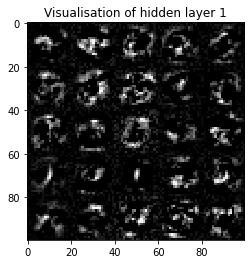

In [20]:
# get 100 random images from the dataset
num_samples = 100
hidden_unit_visual = theta_1[:, 1:]
display_img = Image.new('RGB', (100, 100))

# loop over the images, turn them into a PIL image
i = 0
for col in range(5):
    for row in range(5):
        array = hidden_unit_visual[i]
        array = ((array / max(array)) * 255).reshape((20, 20)).transpose() # redistribute values
        img = Image.fromarray(array)
        display_img.paste(img, (col*20, row*20))
        i += 1

# present display_img
plt.title('Visualisation of hidden layer 1')
plt.imshow(display_img, interpolation='nearest')

### Evaluating the model

Get the accuracy on the training set for the trained values of theta. According to the exercise, you should have an accuracy of about 95%. However, this may vary due to the random initalization.

In [21]:
# Make sure to add 1 to the result as `y` is one indexed while the prediction is 0 indexed.
layer2_activation = add_bias(forward(theta_1, add_bias(X).T).T).T
predictions = forward(theta_2, layer2_activation).T

accuracy = np.mean(np.argmax(predictions, axis = 1) + 1 == y) * 100
'Training set accuracy using the a neural network with the trained values for theta: {:2}%'.format(accuracy)

'Training set accuracy using the a neural network with the trained values for theta: 96.3%'